In [1]:
# training_general_tensor-with_augment_layer
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print(tf.config.list_physical_devices())

Versions of key libraries
---
tensorflow:  2.9.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
IMG_SIZE = 224 #224 # Specify height and width of image to match the input format of the model
IMG_WIDTH = 224 #224  #IMG_SIZE
IMG_HEIGHT = 224  #160  #IMG_SIZE
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

UPLOAD_FOLDER = "static/images/"
class_names = []

# best classification model with VGG as backbone
model_file = "models/self_trained_c_full.hdf5"
# best classification model with ResNet50 as backbone
model_file_res = "models/self_trained_res_full.hdf5"

IMAGE_FOLDER = 'static/images/processed/'

# to use resnet change resnet=True
resnet = False 
pooling = False

In [4]:
# functions

def Contrast(image):

    # converting to LAB color space
    imagelab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(imagelab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl, a, b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return enhanced_img


def Edgeline(image):
    enhanced_img = Contrast(image)

    # Convert to grayscale
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Apply Laplacian filter
    Laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=5)
    Laplacian_img = cv2.convertScaleAbs(Laplacian)

    # Apply mean blur and thresholding
    blurred = cv2.blur(Laplacian_img, (3, 3))
    (_, thresh) = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY)

    # Perform morphology operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    r1 = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, np.ones(
        (10, 10), np.uint8), iterations=3)

    # Find edges and draw them on the original image
    edges = cv2.Canny(r1, 50, 150)
    edges = cv2.bitwise_not(edges)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges


def resize(image):
    height, width, _ = image.shape
    top, bottom, left, right = 0, 0, 0, 0
    if (height > width):
        left = (height-width)//2
        right = height-width-left
    else:
        top = (width-height)//2
        bottom = width-height-top
    return cv2.copyMakeBorder(image, top,
                              bottom,
                              left,
                              right,
                              cv2.BORDER_CONSTANT,
                              value=(255, 255, 255))


def Pic_preprocessing(file):
    
    # Read the image
    image = cv2.imread(UPLOAD_FOLDER+file)

    image = resize(image)
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a median blur to reduce noise in the image
    blur_img = cv2.medianBlur(gray_img, 5)

    # Detect edges based on color contrast
    canny_img = cv2.Canny(blur_img, 100, 200)

    # Create a white background image
    white_bg = np.ones_like(image) * 255

    # Find contours in the canny image
    contours, hierarchy = cv2.findContours(
        canny_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the white background image
    cv2.drawContours(white_bg, contours, -1, (0, 0, 0), 2)

    result = white_bg

    newname = UPLOAD_FOLDER+"processed_"+file
    cv2.imwrite(newname, result)
#     newname = UPLOAD_FOLDER+file
    return newname

def Preprocessing_input(image):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding to create a binary image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE,  # cv2.RETR_EXTERNAL
                                   cv2.CHAIN_APPROX_TC89_L1)  # cv2.CHAIN_APPROX_SIMPLE)

    # Create a white background image with the same shape as the original image
    output = np.ones_like(image) * 255
    output_line = np.ones_like(image) * 255

    # Draw the contours (black lines) on the white background image
    cv2.drawContours(output, contours, -1, (0, 0, 0), thickness=20)
    cv2.drawContours(output_line, contours, -1, (0, 0, 0), thickness=2)

    # Reduce line thickness by eroding the image
    kernel = np.ones((3, 3), np.uint8)
    output = cv2.dilate(output, kernel, iterations=10)

    # Combine output and output_line
    combined_image = cv2.bitwise_and(output, output_line)

    return combined_image


def readImage(image_path):
    return cv2.imread(image_path)


def saveImage(image, image_path):
    cv2.imwrite(image_path, image)


In [5]:
# model functions
def readImagesFromDir(base_img_path=IMAGE_FOLDER):
    dirs = [d for d in listdir(base_img_path) if isdir(
        join(base_img_path, d)) and not d.startswith('.')]

    print(dirs)

    dir_files = []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = [os.path.join(img_path, f)
             for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        dir_files.append(X)
        # print(d)

    # data_dir = Path(base_img_path)
    # image_count = len(list(data_dir.glob('*/*.*')))

    return dir_files, dirs


def process_image(img_file):
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.preprocessing.image.smart_resize(
        img_array, size=(224, 224))
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    img_array = img_array / 255.0

    return img_array


def load_all_models():
    base_model = VGG16(input_shape=(224, 224, 3),  # Shape of our images
                       include_top=False,  # Leave out the last fully connected layer
                       weights='imagenet')

    if resnet:
        base_model = ResNet50(input_shape=(224, 224, 3),  # Shape of our images
                              include_top=False,  # Leave out the last fully connected layer
                              weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
        # print(layer)
    # base_model.summary()
    x = base_model.output
    if pooling:
        x = layers.AveragePooling2D(pool_size=(7, 7))(x)
    x = layers.Flatten()(x)
    model = tf.keras.models.Model(base_model.input, x)
    # model2 = load_model("models/backbone_c.hdf5")
    # model = load_model("models/self_trained.hdf5")
    model2 = load_model(model_file)
    if resnet:
        model2 = load_model(model_file_res)
    return model, model2


def build_feat_dic(model, files):

    features = [model.predict(process_image(f))[0] for f in files]

    return features


def getImageFile(processed: str):
    res = processed.replace("Processed_", "")
    res = res.replace("anime_processed", "sample")
    res = res.replace("old_processed", "sample")
    res = res.replace("processed", "sample")
    return res


extractor_model, classifier = load_all_models()
dir_files, classes = readImagesFromDir()
neigh_models = []
for files in dir_files:
        featureDic = build_feat_dic(extractor_model, files)
        print(len(files))
        print(len(featureDic))
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(featureDic)
        neigh_models.append(neigh)

def findMatch(image):
        # img_file = UPLOAD_FOLDER+"/"+image
        print(image)
        predict_res = extractor_model.predict(process_image(image))[0]
        classify_res = classifier.predict(process_image(image))[0]
        score = tf.nn.softmax(classify_res)
        class_idx = np.argmax(score)
        print(score)
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[class_idx], 100 * np.max(score))
        )

        # print("predict results: ", predict_res)
        nearest = neigh_models[class_idx].kneighbors([predict_res])
        # print(nearest)
        resImage = dir_files[class_idx][nearest[1][0][0]]
        print(resImage)
        # res = {"result": resImage}
        res = {"result": getImageFile(resImage)}
        return res


['cat', 'dress', 'farm', 'hat', 'pants', 'parrot', 'rabbit', 'veg', 'vehicle']
1/1 [==============================] - 0s 16ms/step
19
19
1/1 [==============================] - 0s 16ms/step
20
20
1/1 [==============================] - 0s 16ms/step
57
57
1/1 [==============================] - 0s 16ms/step
24
24
1/1 [==============================] - 0s 16ms/step
21
21
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
20
20
1/1 [==============================] - 0s 16ms/step
20
20
1/1 [==============================] - 0s 31ms/step
44
44
1/1 [==============================] - 0s 16ms/step
60
60


In [6]:
# data
testImages = ["31.jpg",
              "32.jpg",
              "33.jpg",
              "34.jpg",
              "35.jpg",
              "41.png",
              "42.png",
              "43.png",
              "44.png",
              "45.png",
              "46.jpg",
              "51.png",
              "52.png",
              "53.png",
              "54.png",
              "61.png",
              "62.png",
              "63.png",
              "64.png",
              "65.jpg"
             ]

static/images/processed_31.jpg
1/1 [==============================] - 1s 708ms/step
tf.Tensor(
[0.09603439 0.09543128 0.09543584 0.09642255 0.09542976 0.09773824
 0.22007816 0.10799404 0.0954357 ], shape=(9,), dtype=float32)
This image most likely belongs to rabbit with a 22.01 percent confidence.
static/images/processed/rabbit/Rabbit013.jpg


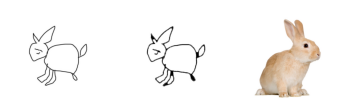

static/images/processed_32.jpg
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09641991 0.09641883 0.09641877 0.12642322 0.09641877 0.09643963
 0.09655097 0.19746126 0.09744863], shape=(9,), dtype=float32)
This image most likely belongs to veg with a 19.75 percent confidence.
static/images/processed/veg/Veg033.jpg


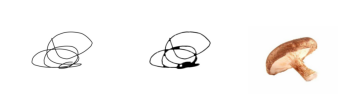

static/images/processed_33.jpg
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09673008 0.24013211 0.09651104 0.09521778 0.09444031 0.09425431
 0.09424254 0.09425506 0.09421668], shape=(9,), dtype=float32)
This image most likely belongs to dress with a 24.01 percent confidence.
static/images/processed/dress/dress006.jpg


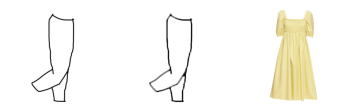

static/images/processed_34.jpg
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.11493547 0.09632037 0.09756213 0.20344707 0.09631426 0.09631778
 0.09637083 0.10168752 0.09704455], shape=(9,), dtype=float32)
This image most likely belongs to hat with a 20.34 percent confidence.
static/images/processed/hat/hat018.jpg


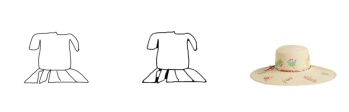

static/images/processed_35.jpg
1/1 [==============================] - 0s 31ms/step
tf.Tensor(
[0.15315637 0.16251622 0.09778317 0.09744829 0.0973413  0.09931182
 0.09784952 0.09729801 0.09729534], shape=(9,), dtype=float32)
This image most likely belongs to dress with a 16.25 percent confidence.
static/images/processed/dress/dress020.jpg


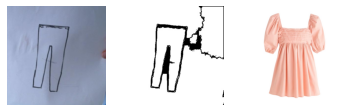

static/images/processed_41.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09362667 0.09362657 0.09362657 0.09440408 0.09362657 0.09362662
 0.09362659 0.24888472 0.0949515 ], shape=(9,), dtype=float32)
This image most likely belongs to veg with a 24.89 percent confidence.
static/images/processed/veg/Veg005.jpg


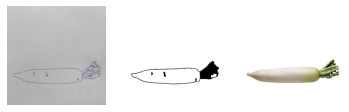

static/images/processed_42.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.2483149  0.09374373 0.09527925 0.09366614 0.09367047 0.09367184
 0.09375086 0.0936707  0.09423207], shape=(9,), dtype=float32)
This image most likely belongs to cat with a 24.83 percent confidence.
static/images/processed/cat/Cat016.jpg


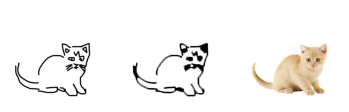

static/images/processed_43.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09339746 0.25338057 0.09331477 0.09331797 0.09331481 0.09331477
 0.09332336 0.0933215  0.09331475], shape=(9,), dtype=float32)
This image most likely belongs to dress with a 25.34 percent confidence.
static/images/processed/dress/dress006.jpg


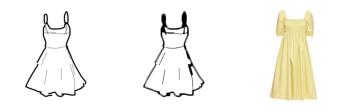

static/images/processed_44.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09620155 0.09622158 0.0961991  0.09620641 0.09619921 0.09623566
 0.12429425 0.20224296 0.09619927], shape=(9,), dtype=float32)
This image most likely belongs to veg with a 20.22 percent confidence.
static/images/processed/veg/Veg038.jpg


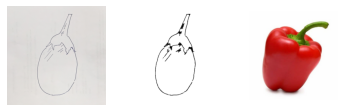

static/images/processed_45.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09367771 0.09367744 0.09367744 0.24811743 0.09367744 0.09367744
 0.0936866  0.096131   0.09367744], shape=(9,), dtype=float32)
This image most likely belongs to hat with a 24.81 percent confidence.
static/images/processed/hat/hat023.jpg


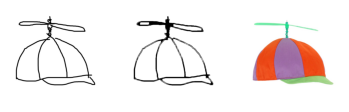

static/images/processed_46.jpg
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09344058 0.09344052 0.09344053 0.09365233 0.09344056 0.09344332
 0.09344052 0.09412257 0.25157908], shape=(9,), dtype=float32)
This image most likely belongs to vehicle with a 25.16 percent confidence.
static/images/processed/vehicle/Vehicle013.jpg


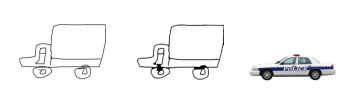

static/images/processed_51.png
1/1 [==============================] - 0s 20ms/step
tf.Tensor(
[0.09659111 0.09630899 0.20220897 0.09622974 0.096224   0.09659335
 0.12338242 0.09623793 0.0962235 ], shape=(9,), dtype=float32)
This image most likely belongs to farm with a 20.22 percent confidence.
static/images/processed/farm/farm006.jpg


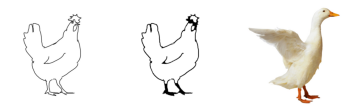

static/images/processed_52.png
1/1 [==============================] - 0s 27ms/step
tf.Tensor(
[0.10138455 0.09767512 0.09765942 0.1060216  0.09765838 0.0976639
 0.1643847  0.13989337 0.09765901], shape=(9,), dtype=float32)
This image most likely belongs to rabbit with a 16.44 percent confidence.
static/images/processed/rabbit/Rabbit004.jpg


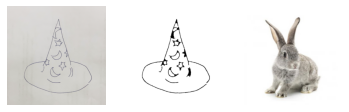

static/images/processed_53.png
1/1 [==============================] - 0s 26ms/step
tf.Tensor(
[0.1311398  0.09654783 0.19290946 0.09654362 0.09654367 0.09664434
 0.09658402 0.09654362 0.09654362], shape=(9,), dtype=float32)
This image most likely belongs to farm with a 19.29 percent confidence.
static/images/processed/farm/farm034.jpg


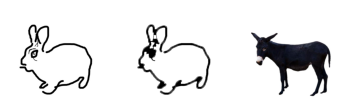

static/images/processed_54.png
1/1 [==============================] - 0s 28ms/step
tf.Tensor(
[0.0932986  0.09329855 0.09329855 0.09329855 0.09329855 0.09329864
 0.25361136 0.09329855 0.09329855], shape=(9,), dtype=float32)
This image most likely belongs to rabbit with a 25.36 percent confidence.
static/images/processed/rabbit/Rabbit007.jpg


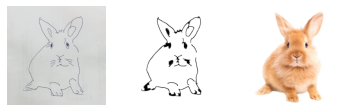

static/images/processed_61.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.25341085 0.0933231  0.09331405 0.09331264 0.09331264 0.09332249
 0.09337892 0.09331265 0.09331264], shape=(9,), dtype=float32)
This image most likely belongs to cat with a 25.34 percent confidence.
static/images/processed/cat/Cat003.jpg


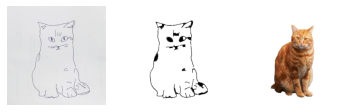

static/images/processed_62.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.09329884 0.25360897 0.09329873 0.09329873 0.09329873 0.09329873
 0.09329981 0.09329873 0.09329873], shape=(9,), dtype=float32)
This image most likely belongs to dress with a 25.36 percent confidence.
static/images/processed/dress/dress009.jpg


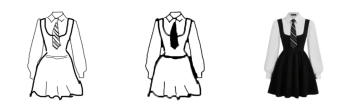

static/images/processed_63.png
1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[0.0932994  0.09329868 0.09329878 0.09329867 0.09329867 0.09329868
 0.09329868 0.09329868 0.25360975], shape=(9,), dtype=float32)
This image most likely belongs to vehicle with a 25.36 percent confidence.
static/images/processed/vehicle/Vehicle059.jpg


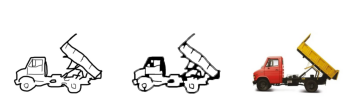

static/images/processed_64.png
1/1 [==============================] - 0s 20ms/step
tf.Tensor(
[0.09362713 0.093353   0.25293964 0.09334575 0.09334565 0.09334673
 0.09335056 0.09334589 0.09334563], shape=(9,), dtype=float32)
This image most likely belongs to farm with a 25.29 percent confidence.
static/images/processed/farm/farm027.jpg


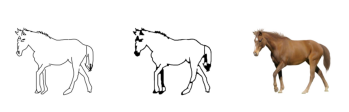

static/images/processed_65.jpg
1/1 [==============================] - 0s 21ms/step
tf.Tensor(
[0.24081892 0.09594989 0.09416713 0.09416664 0.09416664 0.09416664
 0.09823091 0.09416664 0.09416664], shape=(9,), dtype=float32)
This image most likely belongs to cat with a 24.08 percent confidence.
static/images/processed/cat/Cat010.jpg


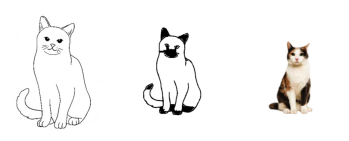

In [7]:
for i,filename in enumerate(testImages):
    
    image = readImage(UPLOAD_FOLDER+filename)
    processedFile = UPLOAD_FOLDER+"processed_"+filename
    processedImage = resize(image)
    processedImage = Preprocessing_input(processedImage)
    saveImage(processedImage, processedFile)
    
    resp = findMatch(processedFile)
    plt.subplot(1, 3, 1)
    img_file = UPLOAD_FOLDER+filename
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    img_file = processedFile
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    plt.imshow(img)
    plt.axis("off")
    plt.subplot(1, 3, 3)
    img_file = resp["result"]
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )
    plt.imshow(img)
    plt.axis("off")
    plt.show()